# import

In [57]:
import gc
import os
import re
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch import nn, optim
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoConfig, AutoModel, AutoTokenizer

In [2]:
pd.set_option("display.max_column", 100)
pd.set_option("display.max_row", 100)

# パラメータの設定

In [3]:
# パラメータの設定
MODELNAME="bert-base-uncased"
config = AutoConfig.from_pretrained(MODELNAME).to_dict()
config["drop_rate"] = 0.4
config["output_size"] = 3
config["train_batch_size"] = 180
config["valid_batch_size"] = 60
config["num_epochs"] = 1
config["learning_rate"] = 1e-4
config["model_name"] = MODELNAME
config["max_token_len"] = 128
config["fold_split"] = 5
config["gradient_checkpoint"] = True
config["freezing"] = True
config["header_type"] = "Linear"

# データの読み込み

In [4]:
df = pd.read_csv(
    "/home/jovyan/work/data/train.csv",
    index_col="discourse_id",
    nrows=1000
)

## データのラベル定義

In [5]:
discourse_types = ["Lead", "Position", "Claim", "Evidence", "Counterclaim", "Concluding Statement", "Rebuttal"]
target_col_names = ["Adequate", "Effective", "Ineffective"]

## データ整形

In [6]:
#下処理:discourse_typeとdiscourse_textを結合する
sep = AutoTokenizer.from_pretrained(config["model_name"]).sep_token
df["inputs"] = df.discourse_type + sep + df.discourse_text

In [7]:
# データの分割
df_train_valid, df_test = train_test_split(
    df, test_size=0.2, shuffle=True, random_state=0, stratify=df["discourse_effectiveness"]
)

## tokenizer, Dataset, BERTClassの定義

In [8]:
#textをtokenizeするクラス(前処理)
class tokenize(object):
    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, text):
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True
        )
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "input_ids": torch.LongTensor(input_ids),
            "attention_mask": torch.LongTensor(attention_mask),
            "token_type_ids": torch.LongTensor(token_type_ids),
        }

In [9]:
# Datasetの定義
class CreateDataset(Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform=transform
    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        text = self.X[index]
        output_dict = self.transform(text)
        output_dict["labels"] = torch.Tensor(self.y[index])
        return output_dict

In [10]:
# Subsetの定義
class CreateSubset(Dataset):
    def __init__(self, X, y, transform, indices):
        self.X = X
        self.y = y
        self.indices = indices
        self.transform = transform

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.indices)

    def __getitem__(self, idx):  # Dataset[index]で返す値を指定
        _X = self.X[self.indices[idx]]
        output_dict = self.transform(_X)
        output_dict["labels"] = torch.Tensor(self.y[self.indices[idx]])
        return output_dict

In [11]:
def freeze(module):
    for parameter in module.parameters():
        parameter.require_grad = False

In [12]:
# BERT分類モデル
class BERTClass(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.bert = AutoModel.from_pretrained(
            self.config["model_name"], output_hidden_states=True
        )
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.fc = nn.Linear(self.config["hidden_size"], self.config["output_size"])
        # Gradient Checkpointing
        if self.config["gradient_checkpoint"]:
            self.bert.gradient_checkpointing_enable()
        # Freeze
        if self.config["freezing"]:
            freeze(self.bert.embeddings)
            freeze(self.bert.encoder.layer[:2])

    def forward(self, input_ids, attention_mask, token_type_ids):
        if self.config["header_type"] == "Linear":
            out = self.bert(
                input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
            )
            out = self.drop(out.hidden_states[-1])
            out = self.fc(out[:, 0, :])
            return out

In [13]:
# BERT分類モデルの定義(Pooling)
class BERTPoolingClass(BERTClass):
    def __init__(self, config):
        super().__init__(config)
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(
            self.config["hidden_size"], self.config["output_size"]
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.bert(
            input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
        )
        out = self.drop(out.hidden_states[-1])
        out, _ = out.max(1)
        out = self.fc(out)
        return out

In [14]:
# BERT分類モデルの定義(Couvolution)
class BERTConvolutionClass(BERTClass):
    def __init__(self, config):
        super().__init__(config)
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.cnn1 = nn.Conv1d(
            self.config["hidden_size"], 256, kernel_size=2, padding=1
        )
        self.cnn2 = nn.Conv1d(256, 1, kernel_size=2, padding=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = (
            self.bert(
                input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
            )
            .hidden_states[-1]
            .permute(0, 2, 1)
        )
        out = nn.functional.relu(self.cnn1(out))
        out = self.cnn2(out)
        out, _ = torch.max(out, 2)
        return out

In [15]:
# BERT分類モデルの定義(Concatenate)
class BERTConcatenateClass(BERTClass):
    def __init__(self, config):
        super().__init__(config)
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.fc = nn.Linear(
            self.config["hidden_size"] * 4, self.config["output_size"]
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.bert(
            input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
        )
        out = torch.cat(
            [out["hidden_states"][-1 * i][:, 0] for i in range(1, 4 + 1)], dim=1
        )  # concatenate
        out = self.fc(out)

        return out

In [16]:
def calculate_loss_f1(model, criterion, loader, device):
    """損失・正解率を計算"""
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            token_type_ids = data["token_type_ids"].to(device)
            labels = data["labels"].to(device)

            # 順伝播
            outputs = model(input_ids, attention_mask, token_type_ids)

            # 損失計算
            loss += criterion(outputs, labels).item()

            # 確率計算
            prob = torch.sigmoid(outputs)
            pred = torch.where(prob > 0.5, 1, 0)

            # f1スコア計算
            f1 = f1_score(pred.cpu().numpy(), labels.cpu().numpy(), average="macro", zero_division=0)

    return loss / len(loader), f1

In [17]:
# EralyStopクラス
class EarlyStopping:
    def __init__(
        self, patience=3, threshold=0.1, verbose=False, path="checkpoint_model.pth"
    ):
        """引数：最小値の非更新数カウンタ、最小値判定の閾値, 表示設定、モデル格納path"""

        self.patience = patience  # 設定ストップカウンタ
        self.threshold = threshold  # 最小値判定の閾値。比率で指定
        self.verbose = verbose  # 表示の有無
        self.counter = 0  # 現在のカウンタ値
        self.early_stop = False  # ストップフラグ
        self.val_loss_min = np.Inf  # 前回のベストスコア記憶用
        self.path = path  # ベストモデル格納path

    def __call__(self, val_loss, model):
        if val_loss > (1 - self.threshold) * self.val_loss_min:  # ベストスコアを更新できなかった場合
            self.counter += 1  # ストップカウンタを+1
            if self.verbose:  # 表示を有効にした場合は経過を表示
                print(
                    f"EarlyStopping counter: {self.counter} out of {self.patience}"
                )  # 現在のカウンタを表示する
            if self.counter >= self.patience:  # 設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
                
        else:  # ベストスコアを更新した場合
            if self.verbose:  # 表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
                print(
                    f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
                )
            torch.save(model.state_dict(), self.path)  # ベストモデルを指定したpathに保存
            
            self.val_loss_min = val_loss
            self.counter = 0  # ストップカウンタリセット

In [19]:
# デバイスの指定
device = torch.device("cpu")
# モデルの定義
model = BERTClass(config)
model.load_state_dict(torch.load("/home/jovyan/work/data/checkpoint/checkpoint_model.pth"))
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [20]:
# Datasetの作成
tokenizer = tokenize(AutoTokenizer.from_pretrained(config["model_name"]), config["max_token_len"])
y = pd.get_dummies(df["discourse_effectiveness"]).to_numpy()
dataset = CreateDataset(df["discourse_text"], y, tokenizer)

In [21]:
def prediction(model, dataset, device):
    # Dataloaderの作成
    loader = DataLoader(dataset, batch_size=100, shuffle=False)

    model.eval()
  
    prob = []
    pred = []
    label = []
    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            token_type_ids = data["token_type_ids"].to(device)
            label.append(data["labels"].to(device))

            # 順伝播 + 予測値の取得 
            outputs = model.forward(input_ids, attention_mask, token_type_ids)
            prob.append(torch.sigmoid(outputs))
            pred.append(torch.where(outputs>0.5, 1, 0))
            
        pred = torch.cat(pred, dim=0)
        prob = torch.cat(prob, dim=0)
        label = torch.cat(label, dim=0)
        
        del model, loader
        gc.collect()
        return pred, label, prob

In [22]:
pred, label, prob = prediction(model, dataset, device)

In [23]:
#precision, recallの算出
def calculate_pr_rc(pred, label):
    pr_rc = []
    for _ in range(label.shape[1]):
        pr = precision_score(pred, label, average="macro")
        rc = recall_score(pred, label, average="macro")
        pr_rc.append([pr, rc])
    return pr_rc

In [24]:
test_pr_rc = pd.DataFrame(
    calculate_pr_rc(pred.numpy(), label.numpy()),
    index=target_col_names,
    columns=["precision", "recall"]
).T

In [25]:
def plot_performance(performances):
    plt.rcParams["font.size"] = 16
    
    length = len(performances.columns)
    
    plt.figure(figsize=(25, 10))
    left = np.arange(length)
    
    plt.bar(left - 0.2, performances.loc["precision", :], width=0.4, label="precision")
    plt.bar(left + 0.2, performances.loc["recall", :], width=0.4, label="recall")
    plt.xticks(np.arange(length), performances.columns.tolist(), rotation=90)
    plt.yticks(np.arange(11)*0.1, np.round(np.arange(11)*0.1, 1))
    plt.grid(axis="y")
    plt.title("precision  vs recall ")
    plt.legend(loc="upper left")
    plt.show()

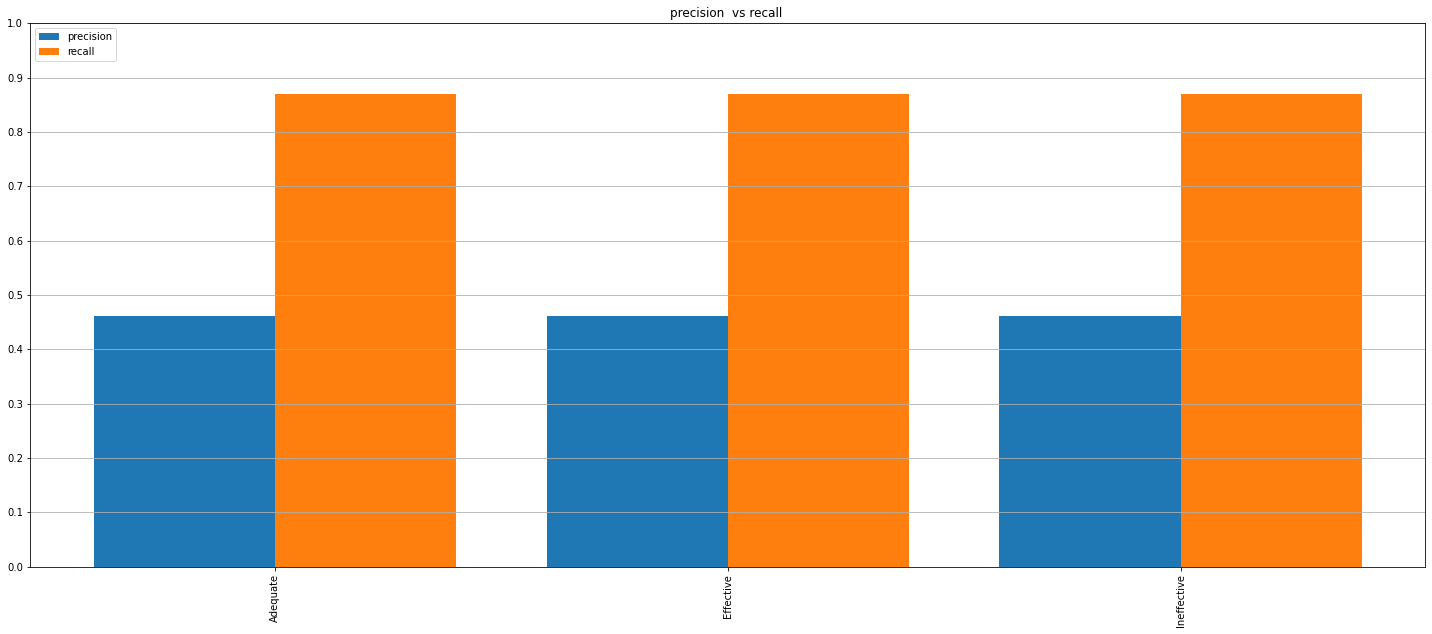

In [26]:
plot_performance(test_pr_rc)

In [27]:
def calc_cross_entropy(y_prob, y_label):
    loss = -1 * np.mean(np.sum( y_label * np.log(y_prob), axis=1))
    return loss

In [28]:
calc_cross_entropy(prob.numpy(), label.numpy())

0.6228377819061279

In [31]:
df

,essay_id,discourse_text,discourse_type,discourse_effectiveness,inputs
discourse_id,,,,,
0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Lead[SEP]Hi, i'm Isaac, i'm going to be writin..."
9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Position[SEP]On my perspective, I think that t..."
c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,Claim[SEP]I think that the face is a natural l...
a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Evidence[SEP]If life was on Mars, we would kno..."
db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,Counterclaim[SEP]People thought that the face ...
...,...,...,...,...,...
aba2bde7e19d,12C08C0F6EE1,A home PC could not take the proper encoding r...,Evidence,Adequate,Evidence[SEP]A home PC could not take the prop...
9af8a9ea55eb,12C08C0F6EE1,The emotional facial reading could be coming t...,Claim,Adequate,Claim[SEP]The emotional facial reading could b...
b8c6a847effb,12C08C0F6EE1,The new technology would be able to tell if a ...,Evidence,Adequate,Evidence[SEP]The new technology would be able ...


In [38]:
confidence_level = -label * np.log(prob)

In [43]:
confidence_level = confidence_level.numpy()

In [46]:
confidence_level= pd.DataFrame(confidence_level)

(array([ 9., 46., 63., 85., 93., 88., 44., 28., 15., 11.,  9., 12.,  7.,
         7.,  7.,  2.,  1.,  3.,  4.,  2.,  2.,  2.,  1.,  3.,  2.,  3.,
         0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
         1.]),
 array([0.13839194, 0.19117007, 0.24394819, 0.29672632, 0.34950444,
        0.40228257, 0.4550607 , 0.50783885, 0.56061697, 0.6133951 ,
        0.6661732 , 0.71895134, 0.77172947, 0.8245076 , 0.8772857 ,
        0.93006384, 0.98284197, 1.0356201 , 1.0883982 , 1.1411763 ,
        1.1939545 , 1.2467326 , 1.2995107 , 1.3522888 , 1.405067  ,
        1.4578451 , 1.5106232 , 1.5634013 , 1.6161795 , 1.6689576 ,
        1.7217357 , 1.7745138 , 1.827292  , 1.8800701 , 1.9328482 ,
        1.9856263 , 2.0384045 , 2.0911825 , 2.1439607 , 2.1967387 ,
        2.249517  ], dtype=float32),
 <BarContainer object of 40 artists>)

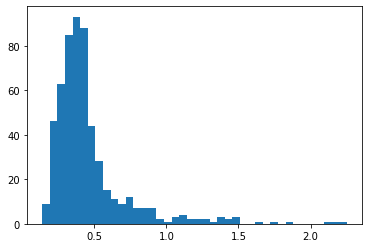

In [80]:
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(confidence_level[confidence_level[0]>0][0], bins=40)

(array([49., 19., 36., 25., 16., 12., 17.,  9.,  9., 11.,  5.,  4.,  3.,
         4.,  2.,  5.,  5.,  2.,  2.,  2.,  2.,  1.,  0.,  1.,  1.,  0.,
         1.,  2.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([0.05659875, 0.1293131 , 0.20202744, 0.27474177, 0.34745613,
        0.42017046, 0.4928848 , 0.56559914, 0.63831353, 0.71102786,
        0.7837422 , 0.8564565 , 0.9291709 , 1.0018852 , 1.0745996 ,
        1.147314  , 1.2200283 , 1.2927426 , 1.3654569 , 1.4381713 ,
        1.5108856 , 1.5835999 , 1.6563144 , 1.7290287 , 1.801743  ,
        1.8744574 , 1.9471717 , 2.019886  , 2.0926003 , 2.1653147 ,
        2.238029  , 2.3107433 , 2.3834577 , 2.4561722 , 2.5288866 ,
        2.601601  , 2.6743152 , 2.7470295 , 2.8197439 , 2.8924582 ,
        2.9651725 ], dtype=float32),
 <BarContainer object of 40 artists>)

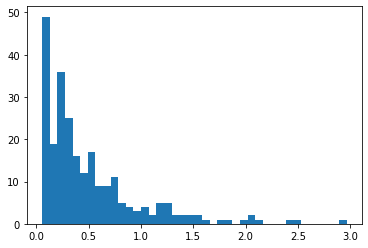

In [81]:
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(confidence_level[confidence_level[1]>0][1], bins=40)

(array([ 4.,  0.,  2.,  3.,  3.,  9., 10.,  9.,  3.,  9., 17., 10., 10.,
        12., 10., 12., 12.,  8.,  4.,  3., 12.,  4.,  4.,  6.,  3.,  3.,
         4.,  0.,  2.,  2.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
         1.]),
 array([0.23218174, 0.30074382, 0.36930588, 0.43786794, 0.50643   ,
        0.57499206, 0.6435541 , 0.7121162 , 0.7806782 , 0.8492403 ,
        0.91780233, 0.9863644 , 1.0549265 , 1.1234885 , 1.1920506 ,
        1.2606127 , 1.3291748 , 1.3977368 , 1.4662988 , 1.534861  ,
        1.603423  , 1.671985  , 1.7405471 , 1.8091092 , 1.8776712 ,
        1.9462333 , 2.0147953 , 2.0833573 , 2.1519194 , 2.2204816 ,
        2.2890437 , 2.3576057 , 2.4261677 , 2.4947298 , 2.5632918 ,
        2.6318538 , 2.7004158 , 2.768978  , 2.8375401 , 2.9061022 ,
        2.9746642 ], dtype=float32),
 <BarContainer object of 40 artists>)

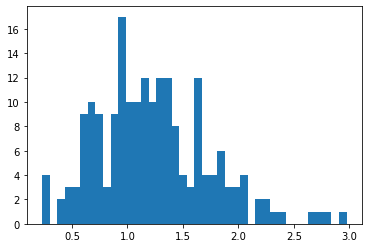

In [83]:
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(confidence_level[confidence_level[2]>0][2], bins=40)

In [88]:
pd.DataFrame(prob.numpy(), index=df.index, columns=[0, 1, 2])

,0,1,2
discourse_id,,,
0013cc385424,0.792999,0.107367,0.095308
9704a709b505,0.777897,0.114652,0.091171
c22adee811b6,0.829303,0.066362,0.087388
a10d361e54e4,0.740788,0.142964,0.099272
db3e453ec4e2,0.760325,0.034019,0.183237
...,...,...,...
aba2bde7e19d,0.642848,0.151498,0.150158
9af8a9ea55eb,0.771421,0.021440,0.231625
b8c6a847effb,0.704624,0.189856,0.083195
